# 感情分析v3

ロジット値でスコア取得してみる．

In [2]:
import os
import sys
import glob
import shutil
import numpy as np
from tqdm import tqdm
import pandas as pd
from pathlib import Path
import japanize_matplotlib
import matplotlib.pyplot as plt

In [3]:
# Goole Colab環境か判断
# ローカル環境とColabo環境の両方で動作させたい(そのうち使う予定)
moduleList = sys.modules
ENV_COLAB = False
if 'google.colab' in moduleList:
    print("google_colab")
    ENV_COLAB = True
else:
    print("Not google_colab")
if ENV_COLAB:
    print("Execute in google_colab")

Not google_colab


## モデル取得

In [4]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline
import torch
import torch.nn.functional as F

In [5]:
from library import tool
from library import preprocess
from library import score

In [6]:
# GPUチェック
tool.is_cuda_available()

gpu is available


In [7]:
# 設定ファイルを読み込み
model_settings = tool.ReadModelTokenizerTome('./settings/model_tokenizer.toml')
model_settings

[pattern1]
tokenizer = "koheiduck/bert-japanese-finetuned-sentiment"
model = "koheiduck/bert-japanese-finetuned-sentiment"
score_folder = "koheiduck_bert-japanese-finetuned-sentiment"

[pattern2]
tokenizer = "A-Funakoshi/bert-multilingual-sentiments-base"
model = "A-Funakoshi/bert-multilingual-sentiments-base"
score_folder = "bert-multilingual-sentiments-base"

[pattern3]
tokenizer = "A-Funakoshi/bert-finetuned-multilingual-sentiments-adamw"
model = "A-Funakoshi/bert-finetuned-multilingual-sentiments-adamw"
score_folder = "bert-finetuned-multilingual-sentiments-adamw"

[pattern4]
tokenizer = "A-Funakoshi/bert-wrime-base"
model = "A-Funakoshi/bert-wrime-base"
score_folder = "bert-wrime-base"

[pattern5]
tokenizer = "A-Funakoshi/bert-base-japanese-v3-wrime-v2"
model = "A-Funakoshi/bert-base-japanese-v3-wrime-v2"
score_folder = "bert-base-japanese-v3-wrime-v2"

In [8]:
# モデルやトークナイザーの名称を定義
PATTERN = 'pattern1'

model_settings.read(PATTERN)
print(model_settings.get_str())

tokenizer:koheiduck/bert-japanese-finetuned-sentiment
model:koheiduck/bert-japanese-finetuned-sentiment
score_folder:koheiduck_bert-japanese-finetuned-sentiment


In [9]:
tokenizer = AutoTokenizer.from_pretrained(model_settings.tokenizer)
model = AutoModelForSequenceClassification.from_pretrained(model_settings.model)

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


### 動作確認

0: NEUTRAL, 1: NEGATIVE, 2: POSITIVE

In [22]:
# 動作確認
cls = pipeline('sentiment-analysis',model=model,tokenizer=tokenizer)
print(cls("私はとっても幸せ"))
print(cls('吾輩は猫である'))
print(cls("私はとっても不幸"))

[{'label': 'POSITIVE', 'score': 0.9896088242530823}]
[{'label': 'NEUTRAL', 'score': 0.9275946021080017}]
[{'label': 'NEGATIVE', 'score': 0.9918387532234192}]


In [23]:
# pipelineを使わないで動作確認
happy_text = '私はとっても幸せ'
happy_text_tokenize = tokenizer.tokenize(happy_text) # tokenize
happy_text_tokenize

['私', 'は', 'とっ', '##て', '##も', '幸せ']

In [24]:
happy_text_encode = tokenizer.encode(happy_text_tokenize) # encode
happy_text_encode

[2, 1325, 9, 3952, 28456, 28480, 13215, 3]

In [25]:
tokenizer.decode(happy_text_encode) # decode

'[CLS] 私 は とっても 幸せ [SEP]'

In [26]:
# unsqueeze調査
print(torch.LongTensor(happy_text_encode).shape)  # long型のtensorに変換
# -> 0番目に次元を追加するということ
print(torch.LongTensor(happy_text_encode).unsqueeze(0).shape) # 上+unsqueeze(0)

torch.Size([8])
torch.Size([1, 8])


In [27]:
# Long型のtensorに変換し軸を追加
happy_text_torch = torch.LongTensor(happy_text_encode).unsqueeze(0)
happy_text_torch

tensor([[    2,  1325,     9,  3952, 28456, 28480, 13215,     3]])

In [28]:
happy_text_output = model(happy_text_torch) # モデルに渡し結果を取得
print(happy_text_output.logits) # Logit値を表示
happy_text_softmax = F.softmax(happy_text_output.logits, dim=1) # Logit値からSoftmax
print(happy_text_softmax)
print(torch.argmax(happy_text_softmax)) # softmaxのargmax

tensor([[-1.3571, -2.2783,  3.5343]], grad_fn=<AddmmBackward0>)
tensor([[0.0074, 0.0030, 0.9896]], grad_fn=<SoftmaxBackward0>)
tensor(2)


### ロジット取得

以下のサイトに掲載されていたコード

https://www.ai-shift.co.jp/techblog/2138

In [29]:
def cut_head_and_tail(text, tokenizer, max_len):
    # まずは限界を設定せずにトークナイズする
    input_ids = tokenizer.encode(text)
    n_token = len(input_ids)

    # トークン数が最大数と同じ場合
    if n_token == max_len:
        input_ids = input_ids
        attention_mask = [1 for _ in range(max_len)]
        token_type_ids = [1 for _ in range(max_len)]
    # トークン数が最大数より少ない場合
    elif n_token < max_len:
        pad = [1 for _ in range(max_len-n_token)]
        input_ids = input_ids + pad
        attention_mask = [1 if n_token > i else 0 for i in range(max_len)]
        token_type_ids = [1 if n_token > i else 0 for i in range(max_len)]
    # トークン数が最大数より多い場合
    else:
        harf_len = (max_len-2)//2
        _input_ids = input_ids[1:-1]
        input_ids = [0]+ _input_ids[:harf_len] + _input_ids[-harf_len:] + [2]
        attention_mask = [1 for _ in range(max_len)]
        token_type_ids = [1 for _ in range(max_len)]

    d = {
        "input_ids": torch.tensor(input_ids, dtype=torch.long),
        "attention_mask": torch.tensor(attention_mask, dtype=torch.long),
        "token_type_ids": torch.tensor(token_type_ids, dtype=torch.long),
    }
    
    return d

In [10]:
x_train = [
    '私はとっても幸せ', 
    '私はとっても不幸',
    '寿限無寿限無五劫のすり切れ海砂利水魚の水行末雲来末風来末食う寝るところに住むところやぶら小路のぶら小路パイポパイポパイポのシューリンガンシューリンガンのグーリンダイグーリンダイのポンポコピーのポンポコナの長久命の長助'
]

In [31]:
# 長ーい文字列
len(tokenizer.encode(x_train[2]*10))

Token indices sequence length is longer than the specified maximum sequence length for this model (782 > 512). Running this sequence through the model will result in indexing errors


782

In [32]:
# 長い文字列でも512で返してくれる
d = cut_head_and_tail(x_train[2]*10, tokenizer, 512)
len(d['input_ids'])

512

In [33]:
# tokenizer自体にtrauncate用パラメータがあった
# https://huggingface.co/docs/transformers/pad_truncation
tmp = tokenizer(x_train[2]*10 , padding=True, truncation=True, return_tensors='pt')
tmp.input_ids[0].shape

torch.Size([512])

In [34]:
tokenize_text = tokenizer(x_train[2]*10, padding=True, truncation=True, return_tensors='pt')
tokenize_text['input_ids'].shape, tokenize_text['token_type_ids'].shape, tokenize_text['attention_mask'].shape

(torch.Size([1, 512]), torch.Size([1, 512]), torch.Size([1, 512]))

In [35]:
# トークン数が512を超える場合は512までを対象とする
token = tokenizer(x_train[2]*10, padding=True, truncation=True, return_tensors='pt')
output = model(token['input_ids'], attention_mask=token['attention_mask']) # モデルに渡し結果を取得
print(output.logits) # Logit値を表示
tensor_text_softmax = F.softmax(output.logits, dim=1) # Logit値からSoftmax
print(tensor_text_softmax)
print(torch.argmax(tensor_text_softmax)) # softmaxのargmax

tensor([[ 0.3961, -1.1681,  0.4048]], grad_fn=<AddmmBackward0>)
tensor([[0.4509, 0.0943, 0.4548]], grad_fn=<SoftmaxBackward0>)
tensor(2)


In [36]:
model.config.id2label

{0: 'NEUTRAL', 1: 'NEGATIVE', 2: 'POSITIVE'}

In [37]:
# バッチ取得
batch = tokenizer(x_train , padding=True, truncation=True, return_tensors='pt')

# スコア取得
with torch.no_grad():
    # outputs = model(batch['input_ids'], attention_mask=batch['attention_mask'])
    outputs = model(**batch)
    print('outputs: \n',outputs,'\n')
    predictions = F.softmax(outputs.logits, dim=1)
    print('logits: \n',outputs.logits.numpy(),'\n')
    print('predictions: \n',predictions,'\n')
    pred = torch.argmax(predictions, dim=1)
    print('prediction: \n', pred,'\n')

labels = torch.max(outputs.logits, dim=1)
# print(labels)

print(f'logit value:{labels.values.numpy()}, logit index: {labels.indices.numpy()}')
print(f'prediction value: {torch.max(predictions, axis=1)}, prediction index: {torch.argmax(predictions, axis=1)}')

outputs: 
 SequenceClassifierOutput(loss=None, logits=tensor([[-1.3571, -2.2783,  3.5343],
        [-1.9614,  3.5475, -1.9304],
        [ 1.1310, -2.0258,  0.6777]]), hidden_states=None, attentions=None) 

logits: 
 [[-1.3570831  -2.2782884   3.5343397 ]
 [-1.9613894   3.5475335  -1.9304135 ]
 [ 1.1310323  -2.0257921   0.67768466]] 

predictions: 
 tensor([[0.0074, 0.0030, 0.9896],
        [0.0040, 0.9918, 0.0041],
        [0.5959, 0.0254, 0.3787]]) 

prediction: 
 tensor([2, 1, 0]) 

logit value:[3.5343397 3.5475335 1.1310323], logit index: [2 1 0]
prediction value: torch.return_types.max(
values=tensor([0.9896, 0.9918, 0.5959]),
indices=tensor([2, 1, 0])), prediction index: tensor([2, 1, 0])


In [38]:
outputs.logits[0]

tensor([-1.3571, -2.2783,  3.5343])

In [39]:
# SoftMax確認
[np.exp(logit)/np.exp(logit).sum() for logit in outputs.logits.numpy()]
# np.exp(outputs.logits[0].numpy())/np.exp(outputs.logits[0].numpy()).sum()

[array([0.00743268, 0.0029585 , 0.98960876], dtype=float32),
 array([0.00401741, 0.99183875, 0.0041438 ], dtype=float32),
 array([0.595927  , 0.02536306, 0.3787099 ], dtype=float32)]

## 小説のテキストで確認

In [14]:
# 定数定義
file_path = 'data/cards/001044/files/edit/4880_ruby_13757.txt'
force = False
save_score=True

In [41]:
pd.read_csv(file_path).head()

,text
0,ネルロとパトラッシュ――この二人はさびしい身の上同志でした。
1,ふたりともこの世に頼るものなく取り残されたひとりぼっち同志ですから、その仲のいいことは言うま...
2,いや、「仲がいい」くらいな言葉では言いあらわせません。
3,兄弟でもこれほど愛し合っている者はまずないでしょう。
4,ほんとにこれ以上の親しさはかんがえられないほどの間柄でした。


In [42]:
x_train[:2]

['私はとっても幸せ', '私はとっても不幸']

In [43]:
batch = tokenizer(x_train[:2], padding=True, truncation=True, return_tensors='pt')
print(batch['input_ids'])
with torch.no_grad():
    results = model(batch['input_ids'], attention_mask=batch['attention_mask'])
    print('results: \n',results,'\n')
    predictions = F.softmax(results.logits, dim=1)
    print('predictions: \n',predictions,'\n')
    pred_max = torch.max(predictions, dim=1).values.numpy()
    print('max(predictions): \n', pred_max, '\n')
    labels = torch.max(results.logits, dim=1)
    values = labels.values.numpy()
    indices = labels.indices.numpy()
    print('values: \n', values, '\n')
    print('indices: \n', indices, '\n')
    # value = label.values.item()
    # index = label.indices.item()

coef_array = [0, -1, 1]
print('coef:', coef_array)

# print([coef_array[i] for i in indices])
logit_values = values * [coef_array[i] for i in indices]
print('value * coef:', logit_values)
pred_values = pred_max * [coef_array[i] for i in indices]
print('pred * coef:', pred_values)

# print(torch.max(predictions, dim=1).values.numpy())
# pred_value = torch.max(prediction).item() * coef_array[index]

# for i, id  in enumerate(indices):
#     print(i, values[i] * coef_array[id])

tensor([[    2,  1325,     9,  3952, 28456, 28480, 13215,     3],
        [    2,  1325,     9,  3952, 28456, 28480, 16018,     3]])


results: 
 SequenceClassifierOutput(loss=None, logits=tensor([[-1.3571, -2.2783,  3.5343],
        [-1.9614,  3.5475, -1.9304]]), hidden_states=None, attentions=None) 

predictions: 
 tensor([[0.0074, 0.0030, 0.9896],
        [0.0040, 0.9918, 0.0041]]) 

max(predictions): 
 [0.9896088  0.99183875] 

values: 
 [3.5343394 3.5475335] 

indices: 
 [2 1] 

coef: [0, -1, 1]
value * coef: [ 3.53433943 -3.54753351]
pred * coef: [ 0.98960882 -0.99183875]


In [11]:
# スコア取得関数（バッチ版）
"""
Arg:
    texts: texts(some line)
Returns:
    max logit (array)
    max prediction (array)
"""
def get_scores(texts):
    # 0: NEUTRAL  -> 0
    # 1: NEGATIVE -> -1
    # 2: POSITIVE -> 1
    coef_array = [0, -1, 1]
    
    batch = tokenizer(texts, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        # forward
        outputs = model(batch['input_ids'], attention_mask=batch['attention_mask'])
        # softmax, 予測値
        predictions = F.softmax(outputs.logits, dim=1)
        pred_max = torch.max(predictions, dim=1).values.numpy()
        # logit
        labels = torch.max(outputs.logits, dim=1)
        values = labels.values.numpy()    # max logit
        indices = labels.indices.numpy()  # max index
    
    logit_values = np.abs(values) * [coef_array[i] for i in indices]
    pred_values = pred_max * [coef_array[i] for i in indices]
    
    return logit_values, pred_values

In [12]:
# スコア取得関数（テキスト版）
"""
Arg:
    text: text(one line)
Returns:
    max logit
    max prediction
"""
def get_score(text):
    # 0: NEUTRAL  -> 0
    # 1: NEGATIVE -> -1
    # 2: POSITIVE -> 1
    coef_array = [0, -1, 1]
    # text: 文字列型を想定
    batch = tokenizer(text, padding=True, truncation=True, return_tensors='pt')

    with torch.no_grad():
        output = model(batch['input_ids'], attention_mask=batch['attention_mask'])
        prediction = F.softmax(output.logits, dim=1)
        label = torch.max(output.logits, dim=1)
        value = label.values.item()
        index = label.indices.item()
    logit_value = np.abs(value) * coef_array[index]
    pred_value = torch.max(prediction).item() * coef_array[index]
    return logit_value, pred_value

In [46]:
# 動作確認(テキスト版)
logit, pred = get_scores('私はとっても幸せ')
print(logit, pred)
logit, pred = get_scores('私はとっても不幸')
print(logit, pred)

[3.53433895] [0.98960882]
[-3.54753304] [-0.99183875]


In [47]:
# 動作確認(バッチ版)
get_scores(x_train[:2])

(array([ 3.53433943, -3.54753351]), array([ 0.98960882, -0.99183875]))

In [48]:
%%time
# バッチ版でスコア取得し測定
df = pd.read_csv(file_path)
logit_scores, pred_scores = get_scores(df['text'].values.tolist())

df['logit_score'] = logit_scores
df['pred_score'] = pred_scores
df.head()

CPU times: user 5min 55s, sys: 1min 2s, total: 6min 57s
Wall time: 43.7 s


,text,logit_score,pred_score
0,ネルロとパトラッシュ――この二人はさびしい身の上同志でした。,1.140868,0.527404
1,ふたりともこの世に頼るものなく取り残されたひとりぼっち同志ですから、その仲のいいことは言うま...,0.590121,0.580861
2,いや、「仲がいい」くらいな言葉では言いあらわせません。,-0.679345,-0.510203
3,兄弟でもこれほど愛し合っている者はまずないでしょう。,-0.395740,-0.552090
4,ほんとにこれ以上の親しさはかんがえられないほどの間柄でした。,1.552841,0.794932


In [15]:
%%time
# テキスト版でスコア取得し測定
df = pd.read_csv(file_path)
logit_score, pred_score = [], []
for i, text in enumerate(tqdm(df['text'])):
    logit, pred = get_score(text)
    logit_score.append(logit)
    pred_score.append(pred)

df['logit_score'] = logit_score
df['pred_score'] = pred_score
df.head()

  0%|          | 0/799 [00:00<?, ?it/s]

100%|██████████| 799/799 [00:18<00:00, 43.79it/s]

CPU times: user 3min 38s, sys: 63.9 ms, total: 3min 38s
Wall time: 18.3 s


,text,logit_score,pred_score
0,ネルロとパトラッシュ――この二人はさびしい身の上同志でした。,1.140869,0.527404
1,ふたりともこの世に頼るものなく取り残されたひとりぼっち同志ですから、その仲のいいことは言うま...,0.590121,0.580862
2,いや、「仲がいい」くらいな言葉では言いあらわせません。,-0.679344,-0.510203
3,兄弟でもこれほど愛し合っている者はまずないでしょう。,-0.395739,-0.552090
4,ほんとにこれ以上の親しさはかんがえられないほどの間柄でした。,1.552842,0.794932


In [16]:
# 指定されたwindowサイズで感情スコアの平均値を取得
def get_score_mean(scores, window_size=10, score_mean_num=100):
    score_mean = []
    slide = int((len(scores) - window_size - 1) / 99)
    for n in range(score_mean_num):
        start = slide * n
        if n == score_mean_num - 1:
            end = len(scores) - 1
        else:
            end = start + window_size
        score_mean.append(np.mean(scores[start:end]))
        # print(f'{n}:len(scores):{len(scores)},st:{start},ed:{end},{scores[end]}{np.array(scores)[-1]}')
    return score_mean

In [51]:
df.shape[0]

799

In [17]:
# 取得したスコア数が100になるように平均化
window_size = int(df.shape[0] / 5)
logit_score_mean = get_score_mean(df['logit_score'], window_size=window_size)
pred_score_mean = get_score_mean(df['pred_score'], window_size=window_size)
print(list(logit_score_mean))
print(list(pred_score_mean))

[-0.05103267855801672, -0.1334705951172601, -0.11421878218838254, -0.11028084575942478, -0.07061004399690989, -0.10958195693275463, -0.16756234589800145, -0.22191882119426187, -0.14919996922308543, -0.13535112568979743, -0.10887508811253421, -0.058783098352405264, -0.03508851152358565, -0.0035629914897792746, 0.011303158160650506, 0.030516740145548334, 0.033552316609043745, -0.021816746056454738, -0.045839514559919727, -0.004153926604948704, 0.012312735963917378, -0.024273441460147593, -0.01605168640988428, -0.0428839181579134, -0.09463907150352525, -0.1396359625102589, -0.20320151137106074, -0.202832190495617, -0.1820466049812125, -0.23726872715560146, -0.28469320250757085, -0.2896553746559335, -0.2762362300974768, -0.27288199183326095, -0.19450635617634035, -0.15685722114717435, -0.14515609200458107, -0.10548105643792723, -0.14052402312463186, -0.21112154653799609, -0.2267290340185915, -0.27032935858335133, -0.3417422199305498, -0.3144857918597617, -0.29848419584380753, -0.3039090544

In [18]:
# スコアを0-1に規格化
def score_normalize(scores):
    return (scores - np.min(scores)) / (np.max(scores) - np.min(scores))

In [19]:
# 規格化
logit_score_norm = score_normalize(logit_score_mean)
pred_score_norm = score_normalize(pred_score_mean)
print(list(logit_score_norm))
print(list(pred_score_norm))

[0.8890002598027935, 0.780818101697777, 0.8060819942972863, 0.8112496947820367, 0.8633091490665343, 0.8121668370959175, 0.7360799602336058, 0.6647486960536629, 0.7601766577187012, 0.7783503069716288, 0.8130944514469381, 0.8788294891844672, 0.9099235736244383, 0.9512940853378097, 0.9708027315896818, 0.9960164542407165, 1.0, 0.9273399311698894, 0.895815178376138, 0.9505186092131416, 0.9721275868273058, 0.9241160431621526, 0.9349053406343795, 0.8996937673871387, 0.8317761826679677, 0.7727273738152306, 0.6893111674880175, 0.6897958222561912, 0.7170724637856831, 0.6446052229660891, 0.5823707281521981, 0.5758589370455816, 0.5934686981706553, 0.5978704194824805, 0.7007217015393833, 0.7501281500310231, 0.7654833828625265, 0.8175483931106857, 0.7715619839339629, 0.678917812920269, 0.658436319103835, 0.6012202054226358, 0.5075060775135164, 0.5432743178330419, 0.5642729949270527, 0.5571540266235772, 0.5192781250445966, 0.5647478965045448, 0.6385243691196313, 0.6358204012943615, 0.72377797552687, 

2種類のスコアを比較

規格化すると，それほど違いはない．

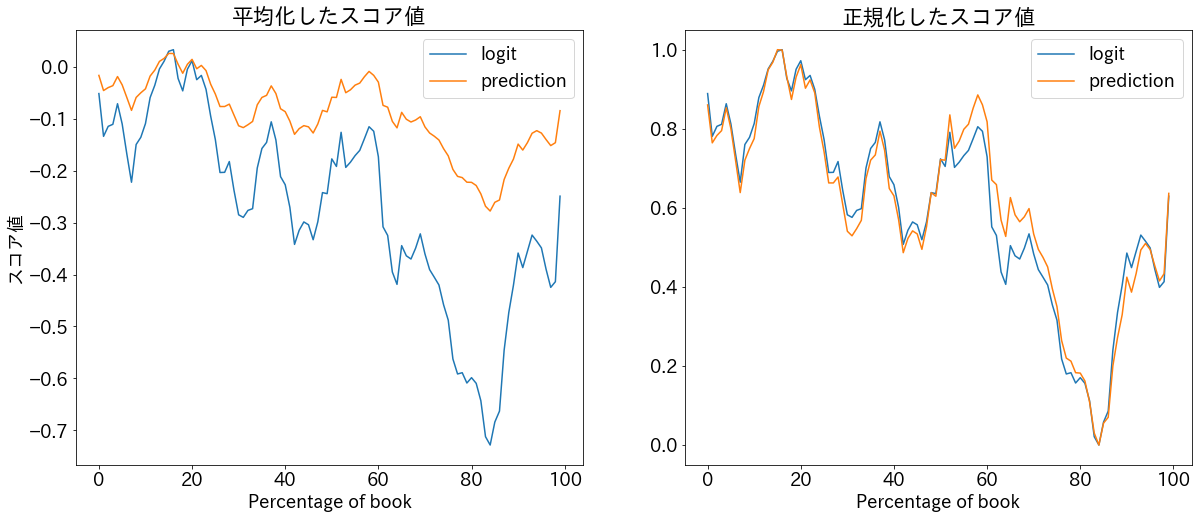

In [21]:
plt.rcParams["font.size"] = 18  # 文字サイズを大きくする

fig = plt.figure(figsize=(20, 8))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.set_title('平均化したスコア値')
ax1.plot(logit_score_mean, label='logit')
ax1.plot(pred_score_mean, label='prediction')
ax1.set_xlabel('Percentage of book')
ax1.set_ylabel('スコア値')
ax1.legend()

ax2.set_title('正規化したスコア値')
ax2.plot(logit_score_norm, label='logit')
ax2.plot(pred_score_norm, label='prediction')
ax2.set_xlabel('Percentage of book')
ax2.legend()

plt.show()

### 別の方法で平均化

- window size: N/5 かつ step: 1で平均化
- window size: 2 かつ step: 1で平均化を繰り返す

In [56]:
df.shape

(799, 3)

In [57]:
# windows size:N/5 and step:1
window_size = int(df.shape[0] / 5)
w = np.ones(window_size)/window_size
logit_score_mean2 = np.convolve(df['logit_score'], w, mode='valid')
len(logit_score_mean2)

641

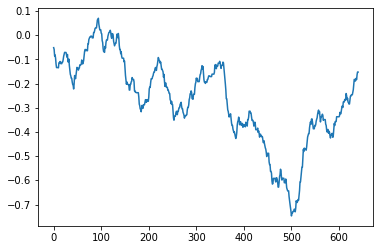

In [58]:
# 描画
plt.plot(logit_score_mean2)

In [59]:
# window_size: 2で固定して100回平均化する関数
def score_mean2(score, iter=100):
    for _ in range(iter):
        window_size = 2
        w = np.ones(window_size)/window_size
        score = np.convolve(score, w, mode='valid')
    
    plt.title(f'length: {len(score)}')
    plt.plot(score)
    plt.show()

    return score

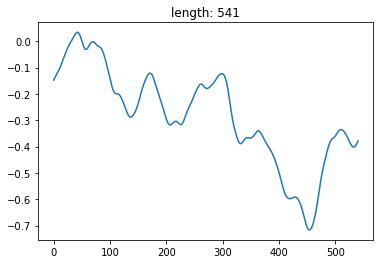

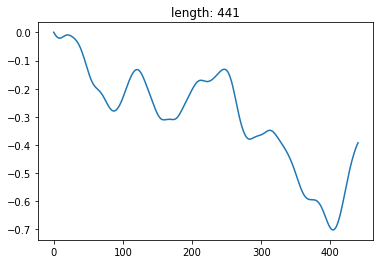

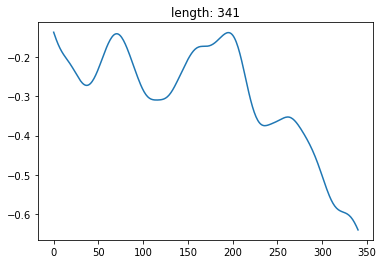

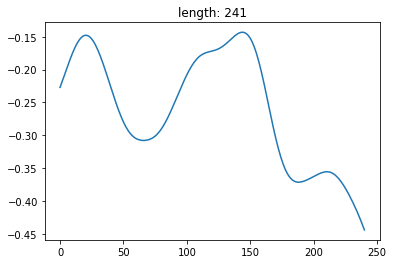

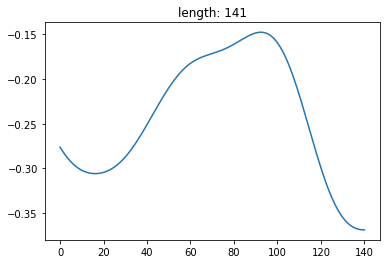

In [60]:
score = logit_score_mean2
for _ in np.arange(5):
    score = score_mean2(score)

形が変わってしまうので，この案はボツ．